In [60]:
# Import packages 
import warnings
import os 
warnings.filterwarnings("ignore")
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

# List of topics 
topic_list = ['technology AI ,technology artificial intelligence','artificial intelligence, AI',
              'future AI, future artificial intelligence','artificial intelligence news',
              'AI update,artifical intelligence update','AI announcement,artifical intelligence announcement ',
              'computer vision','AI market analysis', 'AItrends, artifical intelligence trends','artifical intelligence',
              'ai','NLP','natural language processesing','AI text analysis,artifical intelligence text analysis', 
              'AI speech,artifical intelligence speech','AI healthcare, artifical intelligence healthcare',
              'AI gaming, artifical intelligence gaming','AI finance,artifical intelligence finance',
              'object detection','autonomous vehichles','AI chatbot, artifical intelligence chatbot',
              'facial recongition','new AI,new artifical intelligence','machine learning','technology AI, tech AI','generative AI',
              'LLM, large language model','AI demand']


dfs= [] # Initialize an empty DataFrame to store the combined data
#Iterate through all topics scraped :
for topic in topic_list:
        folder_name = '/Users/annanavarro/Desktop/Azure/News-Sentiment/Articles/'
        file_name = f"{topic}_articles.json"
        file_path = os.path.join(folder_name, file_name)
        df = pd.read_json(file_path)
        dfs.append(df) # Append the DataFrame to the combined DataFrame
df = pd.concat(dfs, ignore_index=True)
df = df.drop_duplicates(subset='url', keep='first')
df['id'] = range(1, len(df) + 1)
df.set_index('id', inplace=True)

df.head()


,source,author,title,description,url,urlToImage,publishedAt,content
id,,,,,,,,
1,Wired,Daron Acemoglu,Get Ready for the Great AI Disappointment,Rose-tinted predictions for artificial intelli...,https://www.wired.com/story/get-ready-for-the-...,https://media.wired.com/photos/659d844b84d51c0...,2024-01-10T12:00:00Z,"In the decades to come, 2023 may be remembered..."
2,The Verge,Verge Staff,We found the smartest gadgets for every room i...,"CES 2024 was full of smart home electronics, f...",https://www.theverge.com/24026790/smart-home-g...,https://cdn.vox-cdn.com/thumbor/PxkNP5tgTRBV6A...,2024-01-13T17:00:00Z,We found the smartest gadgets for every room i...
3,Wired,Ryan Roslansky,The AI-Fueled Future of Work Needs Humans More...,"AI is elbowing its way into ever more jobs, bu...",https://www.wired.com/story/the-ai-fueled-futu...,https://media.wired.com/photos/65b1785b72d6107...,2024-01-26T12:00:00Z,"Much like the internet did in the 1990s, AI is..."
4,Wired,Kate Knibbs,Scammy AI-Generated Books Are Flooding Amazon,Authors keep finding what appear to be AI-gene...,https://www.wired.com/story/scammy-ai-generate...,https://media.wired.com/photos/659ddb4a0694326...,2024-01-10T12:00:00Z,When AI researcher Melanie Mitchell published ...
5,Wired,Will Knight,Etching AI Controls Into Silicon Could Keep Do...,As the US and other countries ponder how to pr...,https://www.wired.com/story/fast-forward-ai-si...,https://media.wired.com/photos/65b1ba4b72d6107...,2024-01-25T17:00:00Z,"Even the cleverest, most cunning artificial in..."


In [61]:
# Identify distribution of domain sources 
source_counts = df['source'].value_counts()
for source, count in source_counts.items():
    print(f"{source}: {count}")
df.shape

Forbes: 426
Business Insider: 110
Yahoo Entertainment: 92
The Verge: 33
Wired: 29
Fox News: 21
NBC News: 8
CNN: 4
BBC News: 3
The Wall Street Journal: 1
USA Today: 1


(728, 8)


 # VADER Method
 - Valance Aware Dictionary and sEntiment Reasoner 
    - Rule-based analysis tool specifically designed to analyze text sentiment in social media content
    - Tuned to handle sland, emoticons, and punctuation  
 - Word assigned a polarity score indicating sentiment intensity 
    - Positive, Negative Neutral 
- Lexicon-based, requires no training data 
- Limitations: Struggle with sarcasm, irony, nuanced language 


In [62]:
# Import VADER sentiment from NLTK library 
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm_notebook

# Create instance of amalyzer 
sia = SentimentIntensityAnalyzer()
res = {}
df.reset_index(inplace = True)



# roBERTa Pretrained Model - https://huggingface.co/docs/transformers/model_doc/roberta
- Pre-trained transformer-based language model built off BERT
- Larger training dataset, longer training duration, dynamic masking strategies, removing next sentence prediction task 
- Labels: 0 -> Negative; 1 -> Neutral; 2 -> Positive    
- Transfer Learning 
- Trained on 58M tweets https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment





In [63]:
# Import packages 
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax   # Converts ouput to probabilities

task = "sentiment"  
MODEL = f"cardiffnlp/twitter-roberta-base-{task}" # Model fine-tuned on Twitter Data
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Return RoBERTA Scores 
def polarity_scores_roberta(example):
    encoded_text= tokenizer(example, return_tensors='pt') # Returns pyTorch tensor 
    output = model(**encoded_text)  # Unpacks dictionary of tokenized inputs and passes as keyword arguments 
    scores = output[0][0].detach().numpy() # Extracts raw score from model output tensor 
    scores = softmax(scores)    # Obtain probability 

    # Construct dictionary containing probabilities for each sentiment class 
    scores_dict = {
        'roberta_neg' :scores[0],
        'roberta_neu' :scores[1],
        'roberta_pos' :scores[2]
    }
    return scores_dict



In [64]:
# Iterates through each row of df perform sentiment analysis on title column
# Using both VADER and RoBERTA model 

res = {}    
for i, row in tqdm_notebook(df.iterrows(), total=len(df)):
    try:
        title = row['title']
        myID = row['id']
        vader_result = sia.polarity_scores(title)
        # Rename each key based on polarity score value 
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        # Calls roBERTA model function 
        roberta_result = polarity_scores_roberta(title)
        if vader_result_rename is not None and roberta_result is not None:
            # Combines results into a single dictionary 
            both = {**vader_result_rename, **roberta_result}    #Unpacking into dictionary 
            res[myID] = both    #Stores sentiment scores with myID as the key 
        else:
            print("Error: One or both dictionaries are None.")
        
    except RuntimeError:
        print(f"Broke for id{myID}")

# Combine results 
results_df = pd.DataFrame(res).T    #Create DF 
results_df = results_df.reset_index().rename(columns={'index': 'id'})
results_df = results_df.merge(df, how='left')
# Include only relevant information 
results_df.drop(columns=['id','author','url', 'urlToImage', 'publishedAt', 'content'],inplace=True)
results_df.head()


  0%|          | 0/728 [00:00<?, ?it/s]

,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,source,title,description
0,0.237,0.288,0.475,0.5106,0.228233,0.495569,0.276197,Wired,Get Ready for the Great AI Disappointment,Rose-tinted predictions for artificial intelli...
1,0.000,0.714,0.286,0.6124,0.001968,0.051992,0.946039,The Verge,We found the smartest gadgets for every room i...,"CES 2024 was full of smart home electronics, f..."
2,0.000,1.000,0.000,0.0000,0.056416,0.541301,0.402283,Wired,The AI-Fueled Future of Work Needs Humans More...,"AI is elbowing its way into ever more jobs, bu..."
3,0.000,0.746,0.254,0.1779,0.518258,0.415586,0.066156,Wired,Scammy AI-Generated Books Are Flooding Amazon,Authors keep finding what appear to be AI-gene...
4,0.297,0.703,0.000,-0.5859,0.182046,0.735641,0.082313,Wired,Etching AI Controls Into Silicon Could Keep Do...,As the US and other countries ponder how to pr...


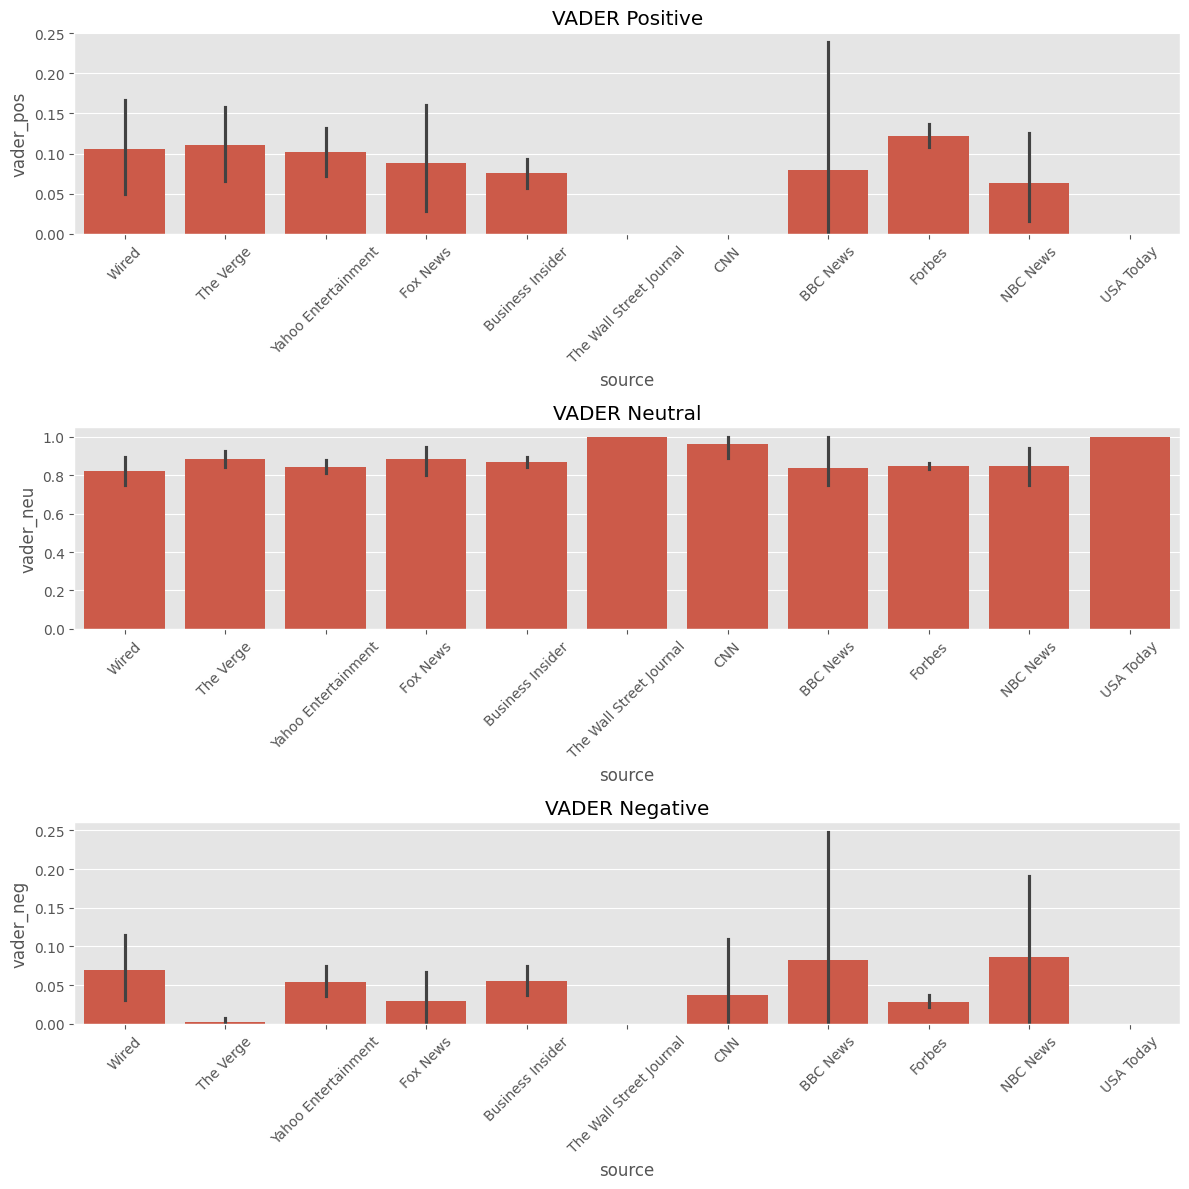

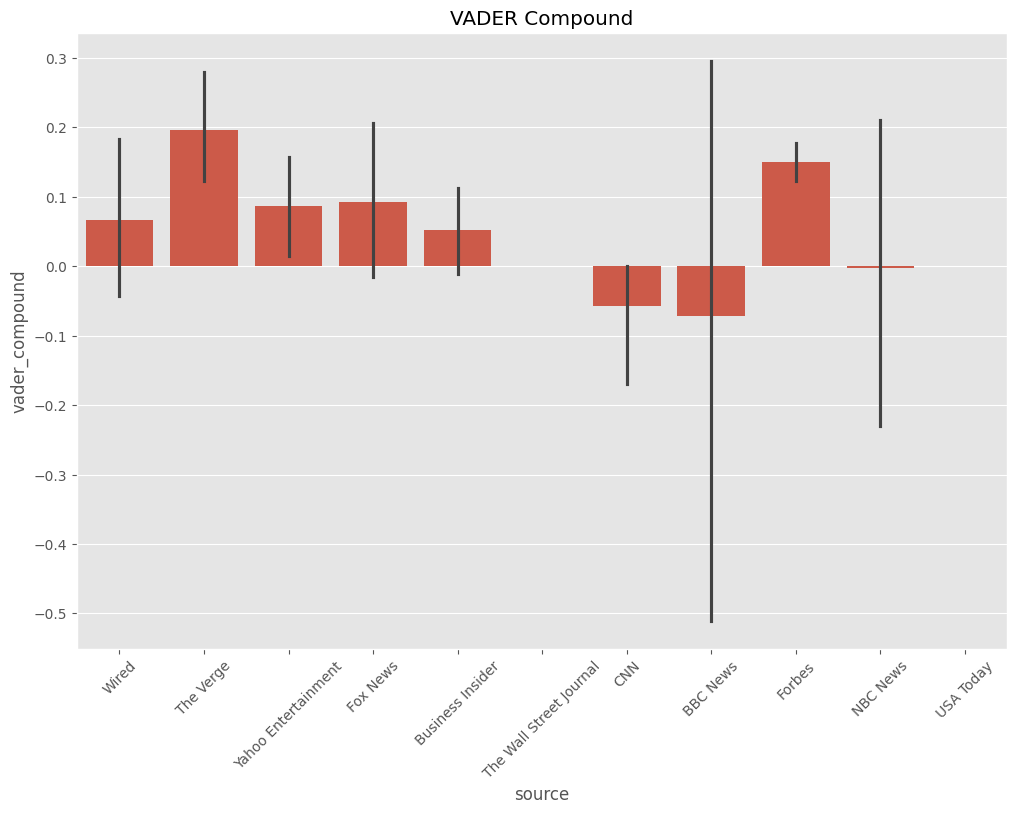

In [65]:
# Plotting VADER Results 
fig, axs = plt.subplots(3,1, figsize=(12,12))
sns.barplot(data=results_df, x= 'source', y='vader_pos',ax=axs[0])
axs[0].set_title('VADER Positive')
sns.barplot(data=results_df, x= 'source', y='vader_neu',ax=axs[1])
axs[1].set_title('VADER Neutral')
sns.barplot(data=results_df, x= 'source', y='vader_neg',ax=axs[2])
axs[2].set_title('VADER Negative')
for ax in axs:
    ax.tick_params(axis='x', rotation= 45)
fig.tight_layout()
plt.show()


# visualize scores
plt.figure(figsize=(12, 8))
ax= sns.barplot(data=results_df, x= 'source', y= 'vader_compound')
ax.set_title("VADER Compound")
plt.xticks(rotation=45)
plt.show()

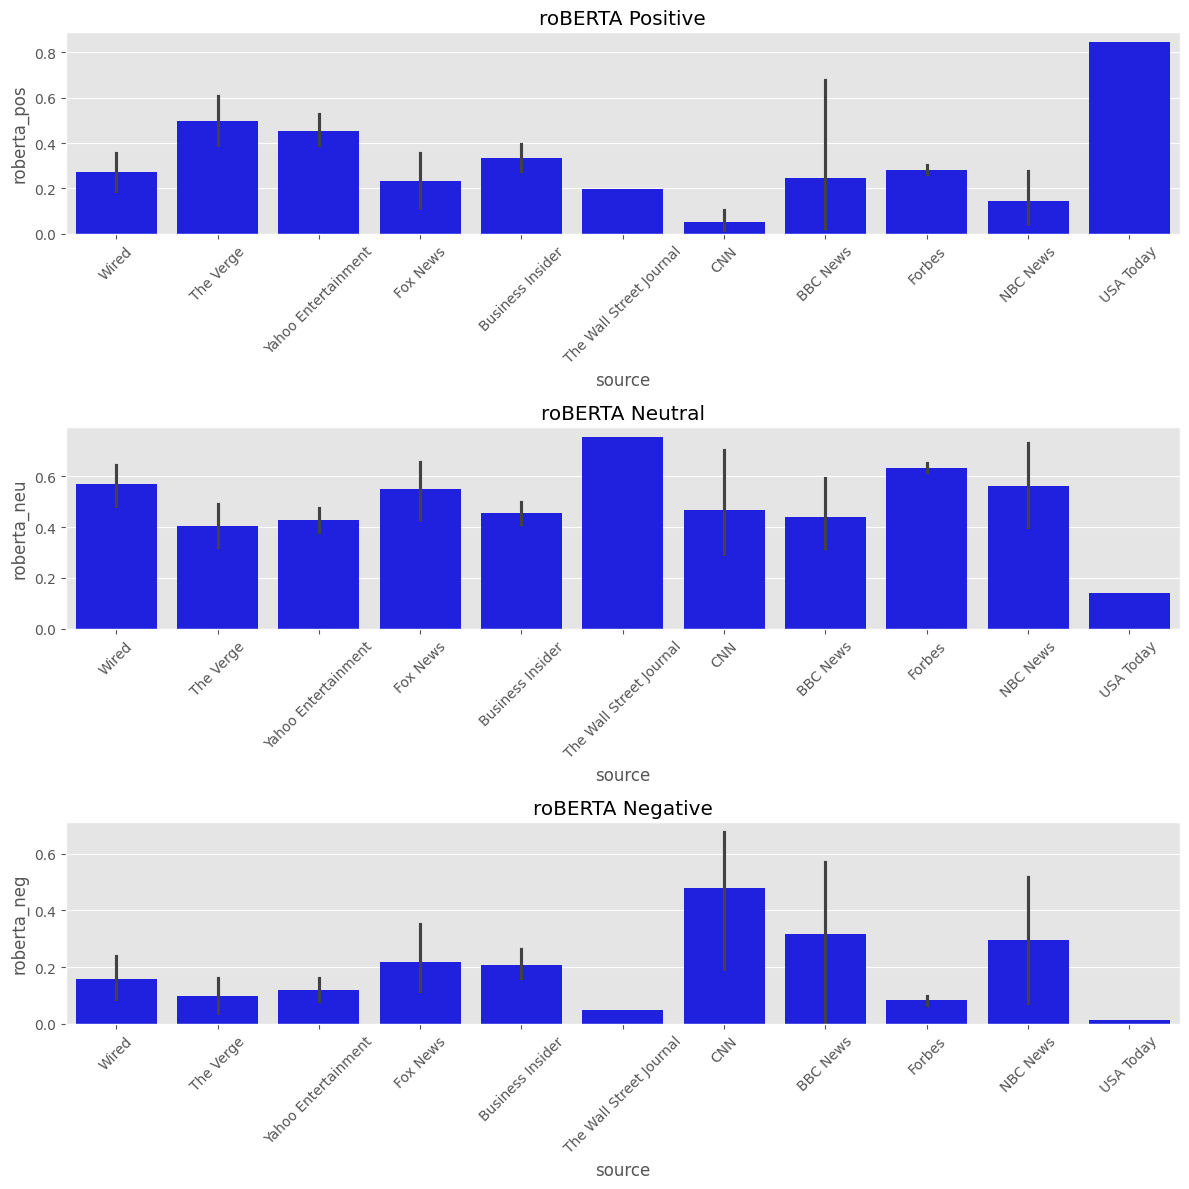

In [66]:
# Plotting roBERTa Results 
fig, axs = plt.subplots(3,1, figsize=(12,12))
sns.barplot(data=results_df, x= 'source', y='roberta_pos',ax=axs[0],color='blue')
axs[0].set_title('roBERTA Positive')
sns.barplot(data=results_df, x= 'source', y='roberta_neu',ax=axs[1], color='blue')
axs[1].set_title('roBERTA Neutral')
sns.barplot(data=results_df, x= 'source', y='roberta_neg',ax=axs[2], color='blue')
axs[2].set_title('roBERTA Negative')
for ax in axs:
    ax.tick_params(axis='x', rotation= 45)
fig.tight_layout()
plt.show()




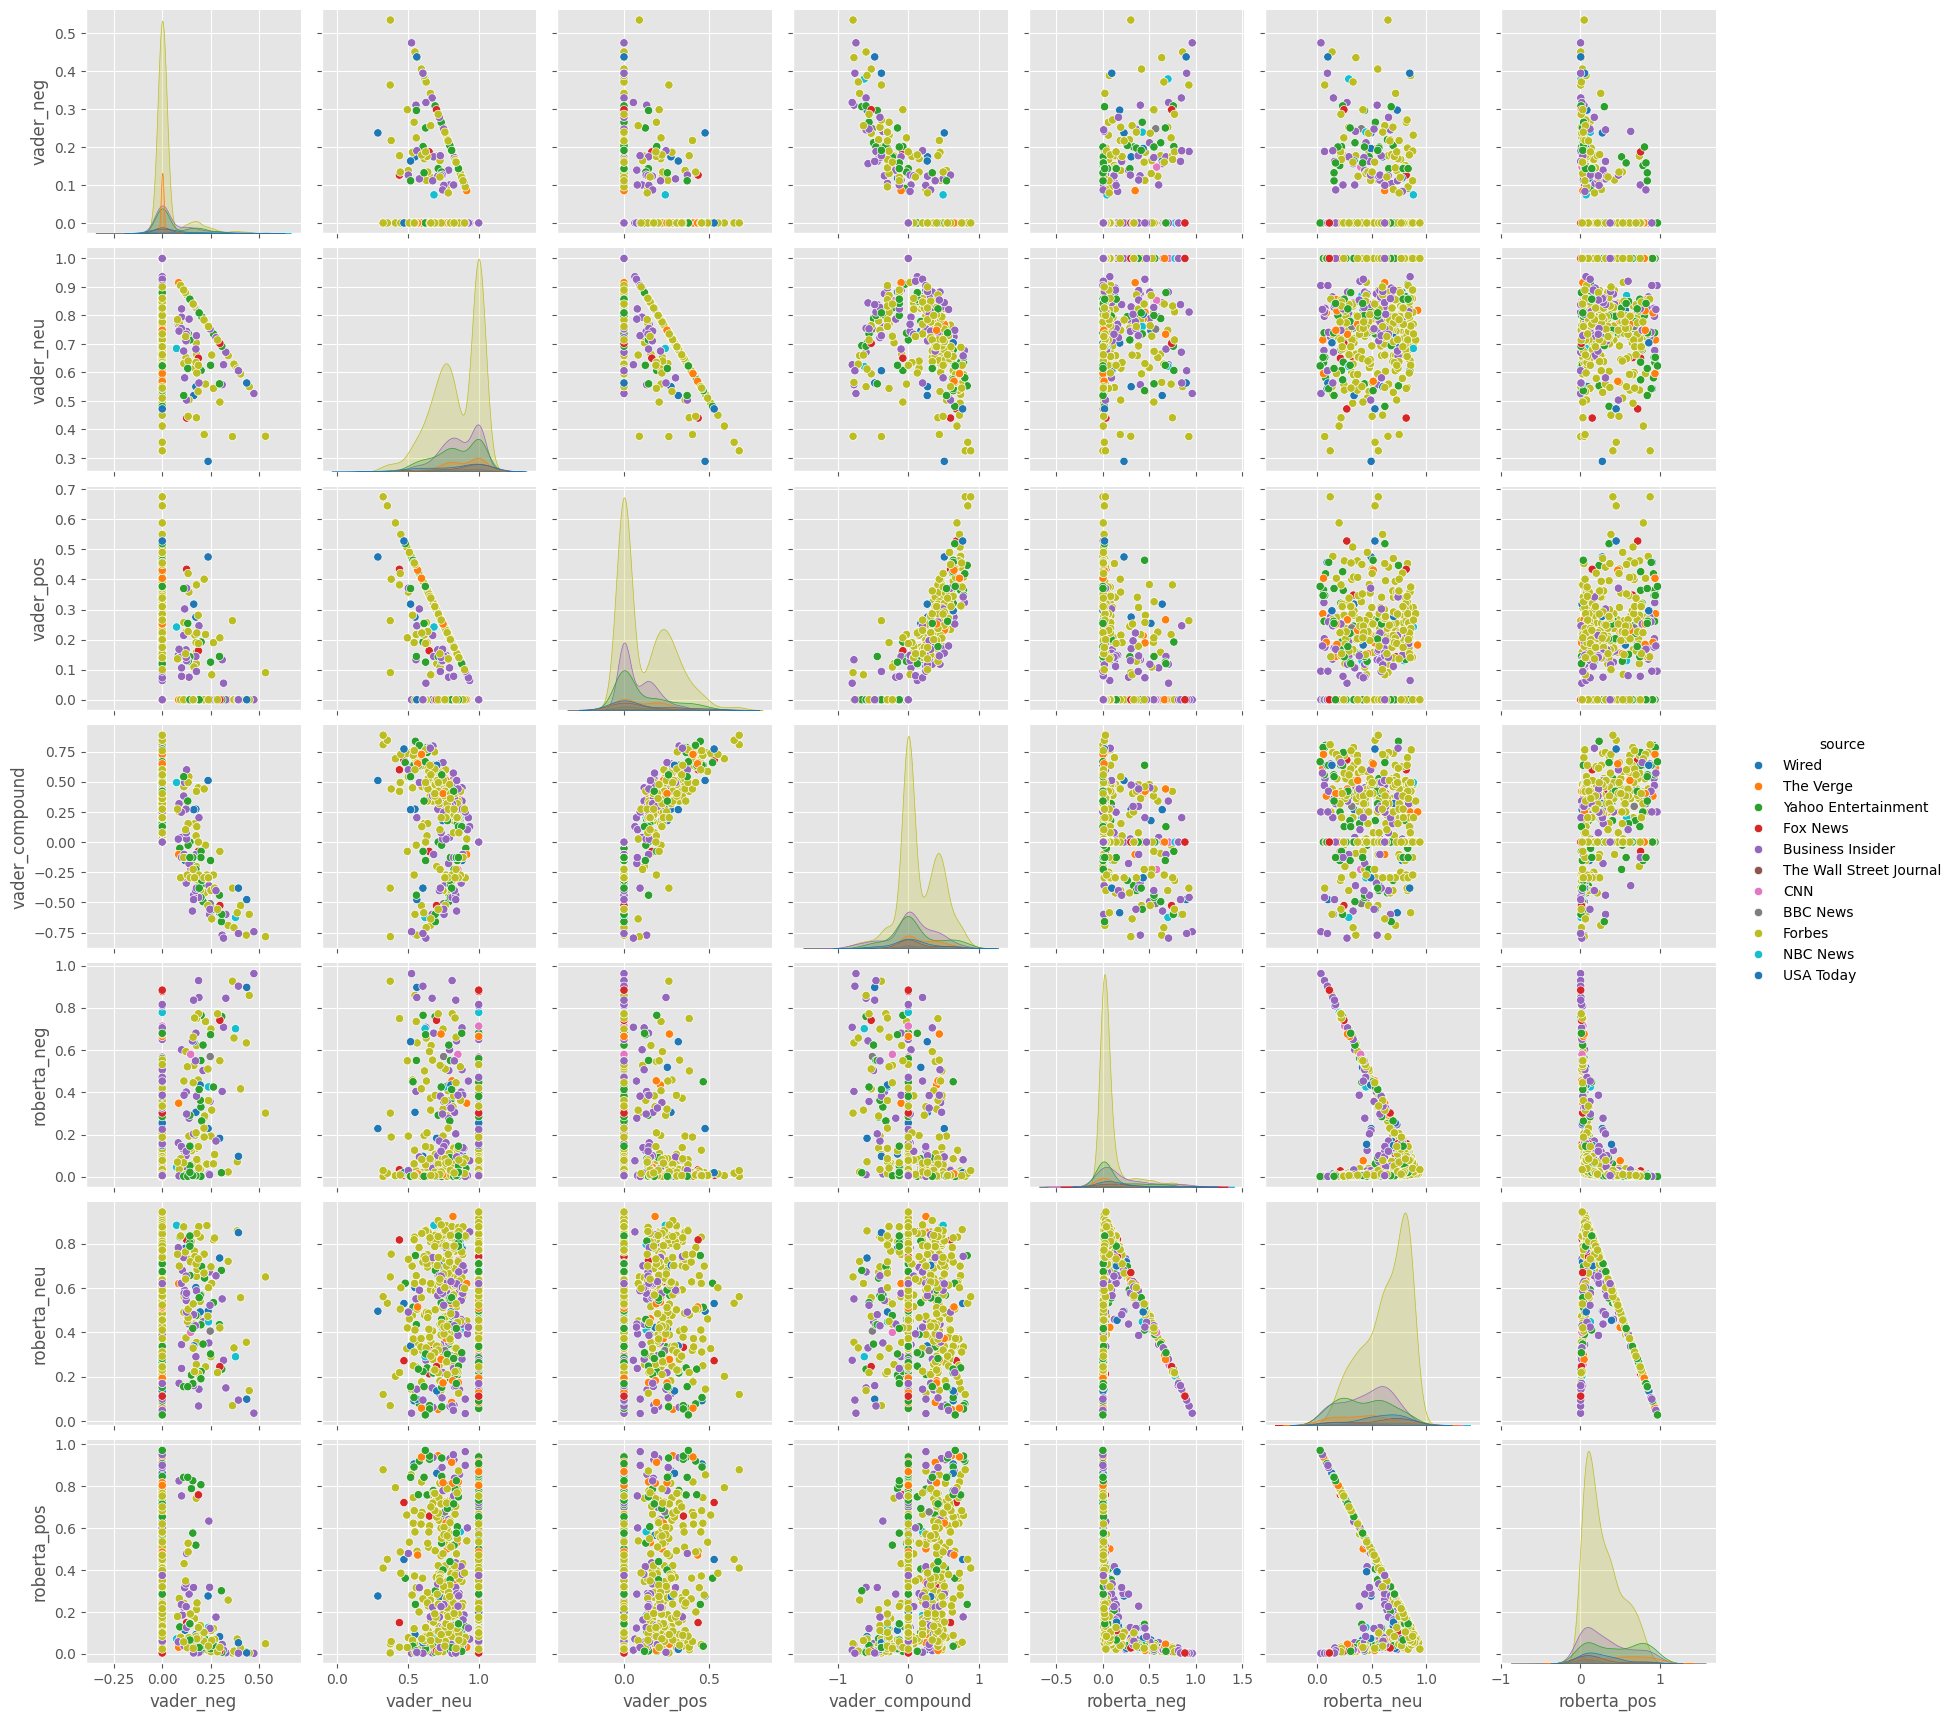

In [67]:
#Compare models
ax = sns.pairplot(data= results_df,
              hue='source',
              palette='tab10',
              corner = False,
              )
plt.show()

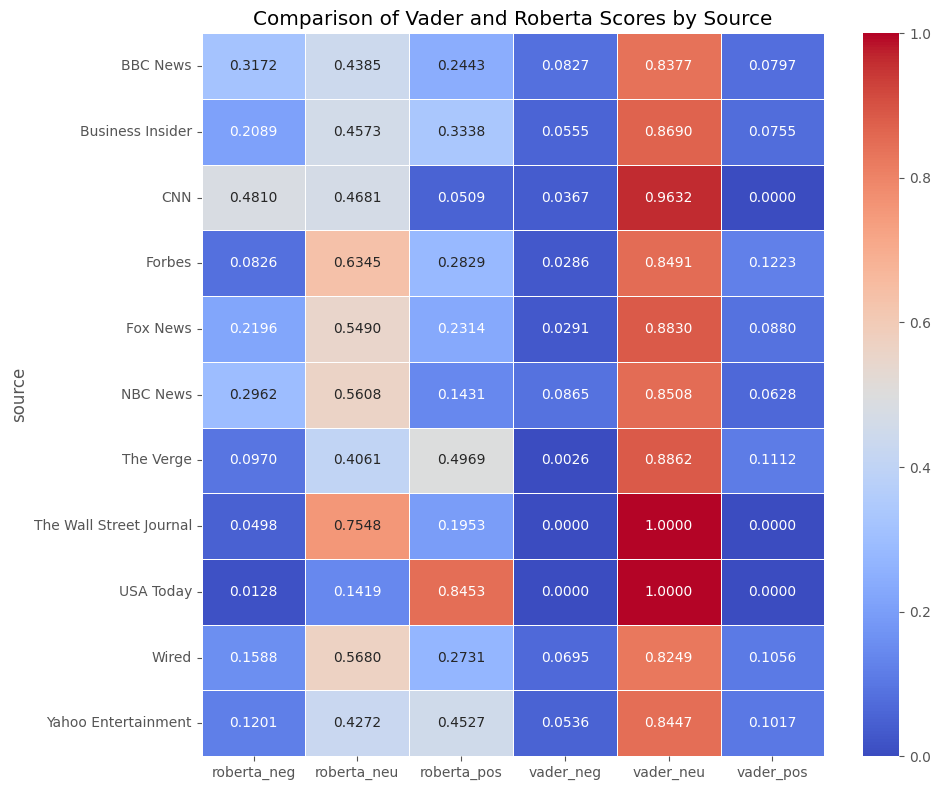

In [68]:
heatmap_data = results_df.pivot_table(index='source', values=['vader_pos', 'vader_neg','vader_neu' ,'roberta_pos', 'roberta_neg','roberta_neu'], aggfunc='mean')

# Create the heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".4f", linewidths=.5)

# Set the title and adjust layout
plt.title("Comparison of VADER and roBERTA Scores by News Source")
plt.tight_layout()

# Show the plot
plt.show()

## Comparing Model Performance 

In [69]:
#review examples 
#positive source 
print("Positive Vader:  " + str(results_df.sort_values('vader_pos',ascending=False)['title'].values[0]))
print("Positive Roberta:  " + str(results_df.sort_values('roberta_pos',ascending=False)['title'].values[0])+"\n")

#negative source
print("Negative Vader:  " + str(results_df.sort_values('vader_pos',ascending=True)['title'].values[0]))
print("Negative Roberta:  " + str(results_df.sort_values('roberta_pos',ascending=True)['title'].values[0]))

Positive Vader:  PETA Travel Awards 2024—The Best Animal Friendly Experiences
Positive Roberta:  Here are the most useful Apple Vision Pro apps at launch

Negative Vader:  Integrating 'Thinking, Fast And Slow' Insights With AI In 2024
Negative Roberta:  AI spam is already starting to ruin the internet


In [70]:

df_sorted = results_df.sort_values(by='roberta_pos', ascending=False)
print("Top 10 roBERTa positive titles: \n")
print("*"*30)
top_titles = []
for title in df_sorted['title'].head(10):
#for title in df_sorted['description'].head(10):  # Loop through the first 10 titles
    top_titles.append(title)
# Display the sorted DataFrame
for title in top_titles:
    print(title)
print("*"*30)

df1_sorted = results_df.sort_values(by='roberta_neg', ascending=False)
print("Top 10 roBERTa negative titles: \n")
print("*"*30)
top_titles = []
#for title in df1_sorted['description'].head(10):
for title in df1_sorted['title'].head(10):  # Loop through the first 10 titles
    top_titles.append(title)
# Display the sorted DataFrame
for title in top_titles:
    print(title)

Top 10 roBERTa positive titles: 

******************************
Here are the most useful Apple Vision Pro apps at launch
Apple's biggest new product since the iPhone, the Vision Pro, launches soon — here's how to order the 'spatial reality' headset
Microsoft's $3 trillion market cap milestone is the latest in a string of wins for Big Tech's elder statesman
We found the smartest gadgets for every room in your home
Nvidia Stock Investors Just Got Amazing News About Its Artificial Intelligence (AI) Chips for 2024
Samsung's big leap in technology with its AI-powered Galaxy S24 series phones
Apple's headset is the company's biggest bet in years
This security camera’s 1.5-mile range is perfect for your sprawling mansion
Nvidia Stock Just Got Amazing Artificial Intelligence (AI) News From These Trillion-Dollar Tech Giants
Vision Pro is Apple's first major push into AI, which will help drive a 30% stock gain this year, Wedbush says
******************************
Top 10 roBERTa negative titles

In [71]:
df_sorted = results_df.sort_values(by='vader_pos', ascending=False)
print("Top 10 VADER positive titles: \n")
print("*"*30)
top_titles = []
#for title in df_sorted['description'].head(10):
for title in df_sorted['title'].head(10):  # Loop through the first 10 titles
    top_titles.append(title)
# Display the sorted DataFrame
for title in top_titles:
    print(title)
print("*"*30)
df1_sorted = results_df.sort_values(by='vader_neg', ascending=False)
print("Top 10 VADER negative titles: \n")
print("*"*30)
top_titles = []
#for title in df1_sorted['description'].head(10):
for title in df1_sorted['title'].head(10):  # Loop through the first 10 titles
    top_titles.append(title)
# Display the sorted DataFrame
for title in top_titles:
    print(title)


Top 10 Vader positive titles: 

******************************
PETA Travel Awards 2024—The Best Animal Friendly Experiences
Qualcomm Earnings Highlight Strong Growth In Automotive
How To Successfully Protect Your AI-Generated Intellectual Property
Apple's Vision Pro's Path To Success
How To Scale Profits Safely With AI
AI Needs to Be Both Trusted and Trustworthy
5 new innovations to help seniors live better
15 Most Advanced Countries in Artificial Intelligence
4 Ways Artificial Intelligence Is Making Companies More Efficient
Using AI To Help Create A Fintech Game-Changer
******************************
Top 10 Vader negative titles: 

******************************
The Code War: A Mad Race For AI Supremacy
AI spam is already starting to ruin the internet
Elections Are Colliding With A Heightened Threat Of Disinformation
Synthetic Data Is a Dangerous Teacher
Pope Francis Warns Of AI Dangers After Fake Image Of Himself Went Viral
Web3’s Silent Threat: Centralized RPC Nodes
AI deepfakes thr

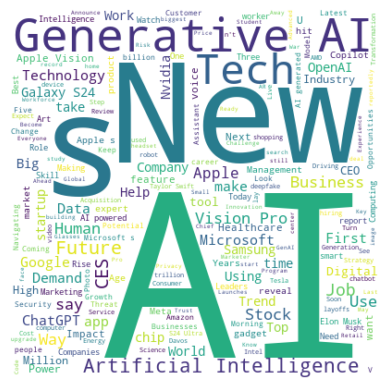

<Figure size 1000x1000 with 0 Axes>

In [74]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
text_data = ' '.join(results_df['title'])
tokens = word_tokenize(text_data)
stop_words = set(stopwords.words('english'))
custom_stop_words = {'S','s', 'will', 'year', 'show'}
stop_words = set(stopwords.words('english')).union(custom_stop_words)


filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
# Combine the filtered tokens back into a single string
filtered_text_data = ' '.join(filtered_tokens)
filtered_text_data

# Generate word cloud
description_wordcloud = WordCloud(width=400, height=400, background_color='white').generate(filtered_text_data)
plt.imshow(description_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.figure(figsize=(10,10))
plt.show()

In [ ]:
# Specify the Excel file path
excel_file_path = 'AI_news_data.xlsx'  # Change this to your desired file path and name

# Export the DataFrame to Excel
results_df.to_excel(excel_file_path, index=False)

print(f'DataFrame exported to Excel file: {excel_file_path}')

DataFrame exported to Excel file: AI_news_data.xlsx
